In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4,5"  # Only GPUs 0 and 1 will be visible to TensorFlow

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:3", "/gpu:4","/gpu:5"])
# strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

2024-10-23 15:37:12.254944: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 15:37:12.268618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 15:37:12.281793: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 15:37:12.285755: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 15:37:12.297529: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5')


2024-10-23 15:37:17.435583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79196 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4e:00.0, compute capability: 8.0
2024-10-23 15:37:17.437102: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79196 MB memory:  -> device: 1, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:4f:00.0, compute capability: 8.0
2024-10-23 15:37:17.438520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79196 MB memory:  -> device: 2, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:c5:00.0, compute capability: 8.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, callbacks


In [3]:

# -----------------------------
# DataLoader Class Definition
# -----------------------------
class DataLoader:
    def __init__(self, h5_filename):
        self.h5_filename = h5_filename
        self.images, self.centers = self.load_data()

    def load_data(self):
        with h5py.File(self.h5_filename, 'r') as f:
            images = np.array(f['images'])
            centers = np.array(f['centers_training'])
        return images, centers

    def plot_image_with_centers(self, image_index=None):
        if image_index is None:
            image_index = np.random.randint(0, len(self.images))

        image = self.images[image_index]
        centers = self.centers[image_index]

        plt.imshow(image, cmap='gray')
        valid_centers = centers[centers[:, 0] == 1]
        for center in valid_centers:
            plt.scatter(center[1], center[2], c='red', marker='o',s=5)  # center[1] is x and center[2] is y
        plt.title('Image with Valid Centers Marked')
        plt.colorbar()
        plt.show()

    @staticmethod
    def sort_centers(centers):
        return centers[np.lexsort((centers[:, 0], centers[:, 1]))]

    def normalize_data(self):
        normalized_images = self.images / np.max(self.images)
        sorted_centers = np.array([self.sort_centers(image_centers[:, 1:]) for image_centers in self.centers])
        normalized_centers = sorted_centers / np.max(centers)

        normalized_midpoints = tf.expand_dims(normalized_centers, axis=1)
        return normalized_images, normalized_midpoints.numpy()

    def split_data(self, train_size=0.8, random_state=42):
        normalized_images, normalized_midpoints_np = self.normalize_data()
        return train_test_split(normalized_images, normalized_midpoints_np, train_size=train_size, random_state=random_state)


In [4]:

# -----------------------------
# Utility Function Definition
# -----------------------------
def plot_transposed_images_with_midpoints(dataset, image_indices=[0, 1, 2, 3]):
    """
    Extracts multiple images and their midpoints from the given dataset, transposes the images, 
    corrects the midpoints, and plots the transposed images with the corrected midpoints.

    Args:
    - dataset (tf.data.Dataset): The dataset from which to extract the images and midpoints.
    - image_indices (list): The indices of the images in the batch to visualize. Default is [0, 1, 2, 3].
    """

    # Extract a sample image batch and its corresponding midpoints from the dataset
    sample_image_batch, sample_midpoints_batch = next(iter(dataset))

    # Create a figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(6, 6))

    for i, ax in enumerate(axes.flat):
        if i < len(image_indices):
            # Select the specified image and corresponding midpoints from the batch
            sample_image = np.array(sample_image_batch[image_indices[i]])
            sample_midpoints = np.array(sample_midpoints_batch[image_indices[i]])

            # Transpose the image
            transposed_image = sample_image.T

            # Correct the midpoints by swapping the x and y coordinates
            transposed_midpoints_corrected = sample_midpoints[:, :, [1, 0]]

            # Plot the transposed image with corrected midpoints
            ax.imshow(transposed_image, cmap='gray')
            ax.scatter(
                transposed_midpoints_corrected[:, :, 0] * 31, 
                transposed_midpoints_corrected[:, :, 1] * 31, 
                c='red', marker='o', s=5
            )
            ax.set_title(f'Image {image_indices[i]} for this batch')
        else:
            ax.axis('off')  # If fewer than 4 images are requested, hide the unused subplots

    plt.tight_layout()
    plt.show()

# -----------------------------
# Custom Loss and Callback Definitions
# -----------------------------
@tf.keras.utils.register_keras_serializable()
def custom_loss(exponent):
    def loss(y_true, y_pred):
        diff = tf.abs(y_true - y_pred)
        powered_diff = tf.pow(diff, exponent)
        return tf.reduce_mean(powered_diff)
    return loss

@tf.keras.utils.register_keras_serializable()
class DynamicExponentCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_exponent, increment, update_frequency):
        super().__init__()
        self.exponent = initial_exponent
        self.increment = increment
        self.update_frequency = update_frequency

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.update_frequency == 0:
            self.exponent += self.increment
            print(f"\nEpoch {epoch + 1}: Increasing exponent to {self.exponent}")
            self.model.loss = self.custom_loss(self.exponent)

    def custom_loss(self, exponent):
        def loss(y_true, y_pred):
            diff = tf.abs(y_true - y_pred)
            powered_diff = tf.pow(diff, exponent)
            return tf.reduce_mean(powered_diff)
        return loss

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'initial_exponent': self.exponent,
            'increment': self.increment,
            'update_frequency': self.update_frequency,
        })
        return config


my NEW model

In [15]:
from tensorflow.keras import layers, regularizers
import tensorflow as tf

class ModelBuilder:
    def __init__(self, input_shape=(32, 32, 1), num_classes=5, num_coordinates=2, learning_rate=1e-3, weights_path=None, l1_reg=0.001, l2_reg=0.007):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.num_coordinates = num_coordinates
        self.learning_rate = learning_rate
        self.l1_reg = l1_reg
        self.l2_reg = l2_reg
        self.model = self.build_model()

        # Load weights if a path is provided
        if weights_path is not None:
            self.model.load_weights(weights_path)

        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

    def build_model(self):
        
        l1 = regularizers.l1(self.l1_reg)
        l2 = regularizers.l2(self.l2_reg)
        
        # # CBAM Attention Block
        # def cbam_block(input_tensor, reduction_ratio=16):
        #     """CBAM block, which includes channel and spatial attention"""
        #     # Channel Attention
        #     channel_attention = layers.GlobalAveragePooling2D()(input_tensor)
        #     channel_attention = layers.Reshape((1, 1, input_tensor.shape[-1]))(channel_attention)
        #     channel_attention = layers.Dense(input_tensor.shape[-1] // reduction_ratio, activation='relu')(channel_attention)
        #     channel_attention = layers.Dense(input_tensor.shape[-1], activation='sigmoid')(channel_attention)
        #     x = layers.Multiply()([input_tensor, channel_attention])

        #     # Spatial Attention
        #     avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
        #     max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
        #     concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
        #     spatial_attention = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(concat)
        #     x = layers.Multiply()([x, spatial_attention])

        #     return x
    
        x_input = layers.Input(shape=self.input_shape)
        
        x = layers.Conv2D(512, kernel_size=19, padding='same', activation='relu',kernel_regularizer=l2)(x_input)
       
        
        x = layers.Flatten()(x)
        
        x_midpoints = layers.Dense(self.num_classes * self.num_coordinates, activation='sigmoid', name='x_midpoints')(x)
        x_midpoints_reshape = layers.Reshape((-1, self.num_classes, self.num_coordinates), name='x_midpoints_reshape')(x_midpoints)
        
        return tf.keras.models.Model(x_input, x_midpoints_reshape)

    def compile_model(self, loss_function):
        self.model.compile(optimizer=self.optimizer, loss=loss_function)

    def train_model(self, train_dataset, val_dataset, epochs, callbacks_list):
        history = self.model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callbacks_list)
        return history


In [6]:

# -----------------------------
# Main Script Execution
# -----------------------------

# Load data
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_Mixed_13.h5'             
h5_filename = '/home/da886/Final Electron counting project/Images and Labels/33KFixed_Mixed_5_32by32_95indexFor19kernel.h5'
# h5_filename = '/home/da886/Final Electron counting project/Images and Labels/30KFixed_13_SparsespotsRandomIndex.h5'
# h5_filename ='/home/da886/Final Electron counting project/Images and Labels/30KFixed-index6_13.h5'
data_loader = DataLoader(h5_filename)
images, centers = data_loader.load_data()


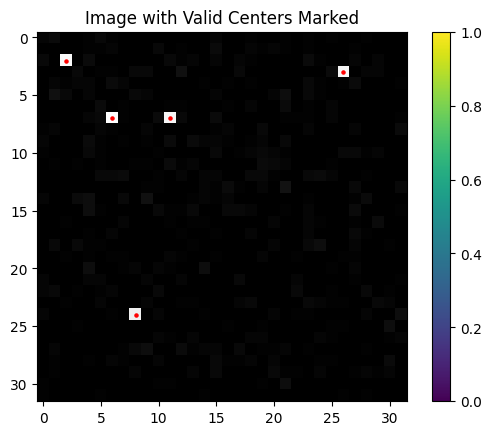

(<matplotlib.image.AxesImage at 0x7f35f42d72c0>, 12504)

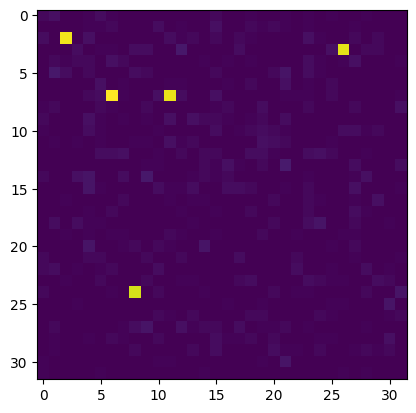

In [7]:
l=np.random.randint(0,len(centers))
data_loader.plot_image_with_centers(l)
plt.imshow(images[l]),l
# plt.grid(True),l

(<matplotlib.image.AxesImage at 0x7f17b8157d90>, 5501)

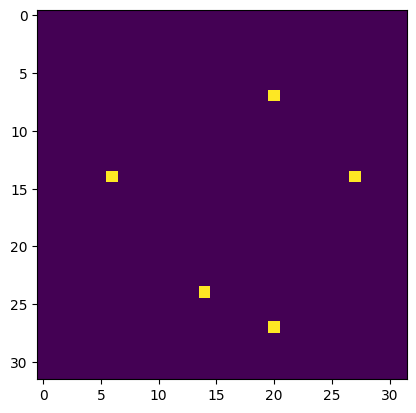

In [9]:
plt.imshow(images[l]),l

In [8]:
t = np.random.randint(0,len(centers))
centers[t]

array([[ 1., 27.,  2.],
       [ 1.,  9., 15.],
       [ 1., 29., 25.],
       [ 1., 15.,  3.],
       [ 1., 22.,  8.]], dtype=float32)

In [9]:

# Normalize the data and split it into training and validation sets
train_images, val_images, train_midpoints, val_midpoints = data_loader.split_data()

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))


In [10]:
np.min(train_images), np.max(train_images), np.min(train_midpoints), np.max(train_midpoints)

(0.0, 1.0, 0.0, 1.0)

In [10]:
np.max(centers)

31.0

In [11]:

batch_size = 1000
train_dataset = train_dataset.shuffle(buffer_size=8000, reshuffle_each_iteration=True).batch(batch_size)
val_dataset = val_dataset.shuffle(buffer_size=8000).batch(batch_size)

# Check the shape of the datasets
print(f'Train Images: {train_images.shape}, Train Midpoints: {train_midpoints.shape}')
print(f'Validation Images: {val_images.shape}, Validation Midpoints: {val_midpoints.shape}')


Train Images: (26400, 32, 32), Train Midpoints: (26400, 1, 5, 2)
Validation Images: (6600, 32, 32), Validation Midpoints: (6600, 1, 5, 2)


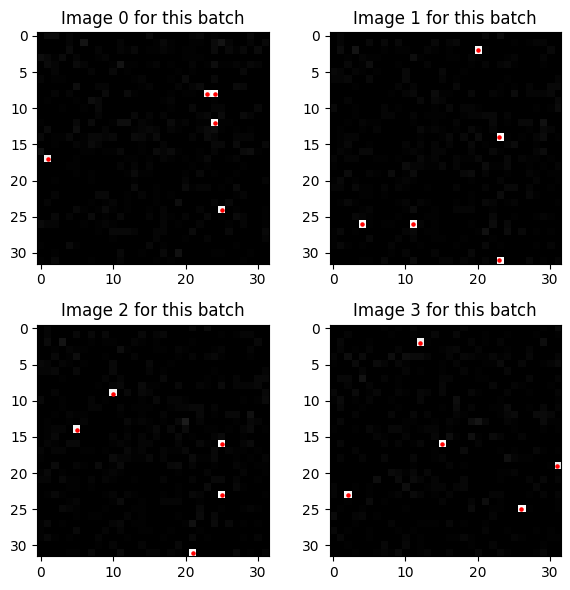

In [12]:
plot_transposed_images_with_midpoints(train_dataset, image_indices=[0, 1, 2, 3])

In [13]:


# Set up learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=10, verbose=1, mode='min', min_lr=7e-6
)


In [16]:

# dynamic_exponent_callback = DynamicExponentCallback(2, 1, 400)


with strategy.scope():
    model_builder = ModelBuilder()

    model_builder.build_model()

    model_builder.model.summary()

    model_builder.compile_model(loss_function=tf.keras.losses.MeanSquaredError()) 
  




Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 512)    │       185,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 524288)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints (Dense)             │ (None, 10)             │     5,242,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ x_midpoints_reshape (Reshape)   │ (None, 1, 5, 2)        │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,428,234 (20.71 MB)

 Trainable params: 5,428,234 (20.71 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:

# Train the model with the custom callback
history = model_builder.train_model(
    train_dataset, 
    val_dataset, 
    epochs=2000,
    callbacks_list=[lr_scheduler]
)


Epoch 1/2000


2024-10-23 15:38:40.019657: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-10-23 15:38:42.111723: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729697922.160110 1976710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697922.182917 1976710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697922.190509 1976710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697922.206710 1976710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697922.221480 1976710 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697922.248491 1976710 gpu_timer.cc

26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0738

2024-10-23 15:38:45.606354: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
2024-10-23 15:38:45.606503: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]
W0000 00:00:1729697925.615476 1976720 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697925.617788 1976720 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697925.621084 1976720 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697925.628001 1976720 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697925.641011 1976720 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be 

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0734

W0000 00:00:1729697926.040386 1976714 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697926.496708 1976719 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697926.506617 1976704 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697926.515882 1976719 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697926.537341 1976719 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697926.546582 1976704 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697926.555040 1976713 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697926.563645 1976719 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697926.574536 1976704 gp

27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 204ms/step - loss: 0.0731 - val_loss: 0.0498 - learning_rate: 0.0010
Epoch 2/2000


W0000 00:00:1729697929.064510 1976712 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697929.101265 1976719 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729697929.112027 1976712 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0463

2024-10-23 15:38:51.168808: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0462 - val_loss: 0.0386 - learning_rate: 0.0010
Epoch 3/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0390 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 4/2000


2024-10-23 15:38:53.843336: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0358 - val_loss: 0.0329 - learning_rate: 0.0010
Epoch 5/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0337 - val_loss: 0.0326 - learning_rate: 0.0010
Epoch 6/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0330

2024-10-23 15:39:00.823857: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0330 - val_loss: 0.0345 - learning_rate: 0.0010
Epoch 7/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0321 - val_loss: 0.0313 - learning_rate: 0.0010
Epoch 8/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0315 - val_loss: 0.0323 - learning_rate: 0.0010
Epoch 9/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0318 - val_loss: 0.0307 - learning_rate: 0.0010
Epoch 10/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0308

2024-10-23 15:39:10.342999: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0308 - val_loss: 0.0304 - learning_rate: 0.0010
Epoch 11/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0313 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 12/2000


2024-10-23 15:39:12.929808: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0303 - val_loss: 0.0313 - learning_rate: 0.0010
Epoch 13/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0309 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 14/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0322 - val_loss: 0.0336 - learning_rate: 0.0010
Epoch 15/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0304 - val_loss: 0.0292 - learning_rate: 0.0010
Epoch 16/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0298 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 17/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0298 - val_loss: 0.0303 - learning_rate: 0.0010
Epoch 18/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0297 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 19/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0298 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 20/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0295 - val_loss: 0.0315 - learning_rate: 0.0010
Epoch 

2024-10-23 15:39:38.807926: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0290 - val_loss: 0.0298 - learning_rate: 0.0010
Epoch 23/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0291

2024-10-23 15:39:41.274402: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0291 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 24/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0299 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 25/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0291 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 26/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0290 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 27/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0296 - val_loss: 0.0294 - learning_rate: 0.0010
Epoch 28/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0288 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 29/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0288 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 30/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0286 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 31/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0291 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 

2024-10-23 15:40:12.608036: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0294 - val_loss: 0.0286 - learning_rate: 0.0010
Epoch 37/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0284 - val_loss: 0.0284 - learning_rate: 0.0010
Epoch 38/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0281 - val_loss: 0.0290 - learning_rate: 0.0010
Epoch 39/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0281 - val_loss: 0.0278 - learning_rate: 0.0010
Epoch 40/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0297 - val_loss: 0.0289 - learning_rate: 0.0010
Epoch 41/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0282 - val_loss: 0.0301 - learning_rate: 0.0010
Epoch 42/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0283 - val_loss: 0.0293 - learning_rate: 0.0010
Epoch 43/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0279 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 44/2000


2024-10-23 15:40:29.500787: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0288 - val_loss: 0.0285 - learning_rate: 0.0010
Epoch 45/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0279 - val_loss: 0.0282 - learning_rate: 0.0010
Epoch 46/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0281 - val_loss: 0.0277 - learning_rate: 0.0010
Epoch 47/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0285 - val_loss: 0.0370 - learning_rate: 0.0010
Epoch 48/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0287 - val_loss: 0.0277 - learning_rate: 0.0010
Epoch 49/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0276

2024-10-23 15:40:43.605871: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0276 - val_loss: 0.0276 - learning_rate: 0.0010
Epoch 50/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0294 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 51/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0283 - val_loss: 0.0273 - learning_rate: 0.0010
Epoch 52/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0282 - val_loss: 0.0283 - learning_rate: 0.0010
Epoch 53/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0277 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 54/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0276 - val_loss: 0.0273 - learning_rate: 0.0010
Epoch 55/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0278 - val_loss: 0.0281 - learning_rate: 0.0010
Epoch 56/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0274 - val_loss: 0.0275 - learning_rate: 0.0010
Epoch 57/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0276 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 

2024-10-23 15:41:14.947150: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0271 - val_loss: 0.0272 - learning_rate: 9.0000e-04
Epoch 63/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0272 - val_loss: 0.0280 - learning_rate: 9.0000e-04
Epoch 64/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0269 - val_loss: 0.0273 - learning_rate: 9.0000e-04
Epoch 65/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0272 - val_loss: 0.0283 - learning_rate: 9.0000e-04
Epoch 66/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0269 - val_loss: 0.0300 - learning_rate: 9.0000e-04
Epoch 67/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0270 - val_loss: 0.0270 - learning_rate: 9.0000e-04
Epoch 68/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0268 - val_loss: 0.0268 - learning_rate: 9.0000e-04
Epoch 69/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0270 - val_loss: 0.0272 - learning_rate: 9.0000e-04
Epoch 70/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0265 - val_loss: 0.028

2024-10-23 15:41:46.150684: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0265 - val_loss: 0.0267 - learning_rate: 9.0000e-04
Epoch 76/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0265 - val_loss: 0.0279 - learning_rate: 9.0000e-04
Epoch 77/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0262 - val_loss: 0.0265 - learning_rate: 9.0000e-04
Epoch 78/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0268 - val_loss: 0.0261 - learning_rate: 9.0000e-04
Epoch 79/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0266 - val_loss: 0.0264 - learning_rate: 9.0000e-04
Epoch 80/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0263 - val_loss: 0.0270 - learning_rate: 9.0000e-04
Epoch 81/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0263 - val_loss: 0.0280 - learning_rate: 9.0000e-04
Epoch 82/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0265 - val_loss: 0.0266 - learning_rate: 9.0000e-04
Epoch 83/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0259 - val_loss: 0.026

2024-10-23 15:42:12.736314: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0259 - val_loss: 0.0263 - learning_rate: 9.0000e-04
Epoch 88/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0257

2024-10-23 15:42:17.322286: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0257 - val_loss: 0.0256 - learning_rate: 9.0000e-04
Epoch 89/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0272 - val_loss: 0.0269 - learning_rate: 9.0000e-04
Epoch 90/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0261 - val_loss: 0.0255 - learning_rate: 9.0000e-04
Epoch 91/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0254 - val_loss: 0.0262 - learning_rate: 9.0000e-04
Epoch 92/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0255 - val_loss: 0.0257 - learning_rate: 9.0000e-04
Epoch 93/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0262 - val_loss: 0.0264 - learning_rate: 9.0000e-04
Epoch 94/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0251 - val_loss: 0.0254 - learning_rate: 9.0000e-04
Epoch 95/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0252 - val_loss: 0.0264 - learning_rate: 9.0000e-04
Epoch 96/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0252 - val_loss: 0.026

2024-10-23 15:42:48.823700: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0248 - val_loss: 0.0265 - learning_rate: 9.0000e-04
Epoch 102/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0248 - val_loss: 0.0256 - learning_rate: 9.0000e-04
Epoch 103/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0250 - val_loss: 0.0257 - learning_rate: 9.0000e-04
Epoch 104/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0245
Epoch 104: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0245 - val_loss: 0.0258 - learning_rate: 9.0000e-04
Epoch 105/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0249 - val_loss: 0.0253 - learning_rate: 8.1000e-04
Epoch 106/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0243 - val_loss: 0.0263 - learning_rate: 8.1000e-04
Epoch 107/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0247 - val_loss: 0.0251 - learning_rate: 8.1000e-04
Epoch 108/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 

2024-10-23 15:43:19.986477: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0243 - val_loss: 0.0251 - learning_rate: 8.1000e-04
Epoch 115/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0247 - val_loss: 0.0247 - learning_rate: 8.1000e-04
Epoch 116/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0242 - val_loss: 0.0251 - learning_rate: 8.1000e-04
Epoch 117/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0247 - val_loss: 0.0258 - learning_rate: 8.1000e-04
Epoch 118/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0242
Epoch 118: ReduceLROnPlateau reducing learning rate to 0.0007290000503417104.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0242 - val_loss: 0.0253 - learning_rate: 8.1000e-04
Epoch 119/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0238 - val_loss: 0.0249 - learning_rate: 7.2900e-04
Epoch 120/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0237 - val_loss: 0.0244 - learning_rate: 7.2900e-04
Epoch 121/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 

2024-10-23 15:43:51.214736: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0239 - val_loss: 0.0249 - learning_rate: 7.2900e-04
Epoch 128/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0237 - val_loss: 0.0246 - learning_rate: 7.2900e-04
Epoch 129/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0236 - val_loss: 0.0251 - learning_rate: 7.2900e-04
Epoch 130/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0236
Epoch 130: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0236 - val_loss: 0.0253 - learning_rate: 7.2900e-04
Epoch 131/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0234 - val_loss: 0.0241 - learning_rate: 6.5610e-04
Epoch 132/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0232 - val_loss: 0.0247 - learning_rate: 6.5610e-04
Epoch 133/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0233 - val_loss: 0.0245 - learning_rate: 6.5610e-04
Epoch 134/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 

2024-10-23 15:44:22.778059: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0235 - val_loss: 0.0242 - learning_rate: 6.5610e-04
Epoch 141/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0230
Epoch 141: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0230 - val_loss: 0.0252 - learning_rate: 6.5610e-04
Epoch 142/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0231 - val_loss: 0.0243 - learning_rate: 5.9049e-04
Epoch 143/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0230 - val_loss: 0.0243 - learning_rate: 5.9049e-04
Epoch 144/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0230 - val_loss: 0.0242 - learning_rate: 5.9049e-04
Epoch 145/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0232 - val_loss: 0.0250 - learning_rate: 5.9049e-04
Epoch 146/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0230 - val_loss: 0.0244 - learning_rate: 5.9049e-04
Epoch 147/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 

2024-10-23 15:44:54.286277: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0230 - val_loss: 0.0247 - learning_rate: 5.9049e-04
Epoch 154/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0230 - val_loss: 0.0244 - learning_rate: 5.9049e-04
Epoch 155/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0229 - val_loss: 0.0245 - learning_rate: 5.9049e-04
Epoch 156/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0229 - val_loss: 0.0244 - learning_rate: 5.9049e-04
Epoch 157/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0230 - val_loss: 0.0240 - learning_rate: 5.9049e-04
Epoch 158/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0229 - val_loss: 0.0237 - learning_rate: 5.9049e-04
Epoch 159/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0228 - val_loss: 0.0241 - learning_rate: 5.9049e-04
Epoch 160/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0229 - val_loss: 0.0241 - learning_rate: 5.9049e-04
Epoch 161/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0229 - val_los

2024-10-23 15:45:25.811541: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0227 - val_loss: 0.0240 - learning_rate: 5.9049e-04
Epoch 167/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0229 - val_loss: 0.0240 - learning_rate: 5.9049e-04
Epoch 168/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0226 - val_loss: 0.0246 - learning_rate: 5.9049e-04
Epoch 169/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0229 - val_loss: 0.0234 - learning_rate: 5.9049e-04
Epoch 170/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0227 - val_loss: 0.0239 - learning_rate: 5.9049e-04
Epoch 171/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0225 - val_loss: 0.0240 - learning_rate: 5.9049e-04
Epoch 172/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0226 - val_loss: 0.0240 - learning_rate: 5.9049e-04
Epoch 173/2000


2024-10-23 15:45:40.490100: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0230 - val_loss: 0.0240 - learning_rate: 5.9049e-04
Epoch 174/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0233 - val_loss: 0.0238 - learning_rate: 5.9049e-04
Epoch 175/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0225 - val_loss: 0.0238 - learning_rate: 5.9049e-04
Epoch 176/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0225 - val_loss: 0.0241 - learning_rate: 5.9049e-04
Epoch 177/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0224 - val_loss: 0.0252 - learning_rate: 5.9049e-04
Epoch 178/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0227 - val_loss: 0.0235 - learning_rate: 5.9049e-04
Epoch 179/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0225

2024-10-23 15:45:57.405244: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 179: ReduceLROnPlateau reducing learning rate to 0.0005314410547725857.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0225 - val_loss: 0.0241 - learning_rate: 5.9049e-04
Epoch 180/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0224 - val_loss: 0.0232 - learning_rate: 5.3144e-04
Epoch 181/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0223 - val_loss: 0.0239 - learning_rate: 5.3144e-04
Epoch 182/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0223 - val_loss: 0.0242 - learning_rate: 5.3144e-04
Epoch 183/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0224 - val_loss: 0.0243 - learning_rate: 5.3144e-04
Epoch 184/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0226 - val_loss: 0.0234 - learning_rate: 5.3144e-04
Epoch 185/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0224 - val_loss: 0.0237 - learning_rate: 5.3144e-04
Epoch 186/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0222 - val_loss: 0.0240 - learning_rate: 5.3144e-04


2024-10-23 15:46:28.744998: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0221 - val_loss: 0.0237 - learning_rate: 4.7830e-04
Epoch 193/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0221 - val_loss: 0.0235 - learning_rate: 4.7830e-04
Epoch 194/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0222 - val_loss: 0.0241 - learning_rate: 4.7830e-04
Epoch 195/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0221 - val_loss: 0.0234 - learning_rate: 4.7830e-04
Epoch 196/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0222 - val_loss: 0.0237 - learning_rate: 4.7830e-04
Epoch 197/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0221 - val_loss: 0.0237 - learning_rate: 4.7830e-04
Epoch 198/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0222 - val_loss: 0.0235 - learning_rate: 4.7830e-04
Epoch 199/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0221 - val_loss: 0.0243 - learning_rate: 4.7830e-04
Epoch 200/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0222
Epoch 200

2024-10-23 15:47:00.294637: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0219 - val_loss: 0.0232 - learning_rate: 4.3047e-04
Epoch 206/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0220 - val_loss: 0.0237 - learning_rate: 4.3047e-04
Epoch 207/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0218 - val_loss: 0.0241 - learning_rate: 4.3047e-04
Epoch 208/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0220 - val_loss: 0.0232 - learning_rate: 4.3047e-04
Epoch 209/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0220 - val_loss: 0.0233 - learning_rate: 4.3047e-04
Epoch 210/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0219 - val_loss: 0.0232 - learning_rate: 4.3047e-04
Epoch 211/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0219 - val_loss: 0.0234 - learning_rate: 4.3047e-04
Epoch 212/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0217
Epoch 212: ReduceLROnPlateau reducing learning rate to 0.00038742052274756136.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss:

2024-10-23 15:47:31.850589: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0218 - val_loss: 0.0234 - learning_rate: 3.8742e-04
Epoch 219/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0217 - val_loss: 0.0234 - learning_rate: 3.8742e-04
Epoch 220/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0217 - val_loss: 0.0231 - learning_rate: 3.8742e-04
Epoch 221/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0219 - val_loss: 0.0235 - learning_rate: 3.8742e-04
Epoch 222/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0217 - val_loss: 0.0236 - learning_rate: 3.8742e-04
Epoch 223/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0217 - val_loss: 0.0237 - learning_rate: 3.8742e-04
Epoch 224/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0216
Epoch 224: ReduceLROnPlateau reducing learning rate to 0.0003486784757114947.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0216 - val_loss: 0.0237 - learning_rate: 3.8742e-04
Epoch 225/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 

2024-10-23 15:48:03.316991: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0216 - val_loss: 0.0231 - learning_rate: 3.4868e-04
Epoch 232/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0217 - val_loss: 0.0235 - learning_rate: 3.4868e-04
Epoch 233/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0214 - val_loss: 0.0233 - learning_rate: 3.4868e-04
Epoch 234/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0218 - val_loss: 0.0235 - learning_rate: 3.4868e-04
Epoch 235/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0216 - val_loss: 0.0230 - learning_rate: 3.4868e-04
Epoch 236/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0216 - val_loss: 0.0229 - learning_rate: 3.4868e-04
Epoch 237/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0216 - val_loss: 0.0231 - learning_rate: 3.4868e-04
Epoch 238/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0217 - val_loss: 0.0234 - learning_rate: 3.4868e-04
Epoch 239/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0215 - val_los

2024-10-23 15:48:34.566283: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0216 - val_loss: 0.0230 - learning_rate: 3.1381e-04
Epoch 245/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0214 - val_loss: 0.0233 - learning_rate: 3.1381e-04
Epoch 246/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0215 - val_loss: 0.0236 - learning_rate: 3.1381e-04
Epoch 247/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0215 - val_loss: 0.0235 - learning_rate: 3.1381e-04
Epoch 248/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0216 - val_loss: 0.0230 - learning_rate: 3.1381e-04
Epoch 249/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0214 - val_loss: 0.0231 - learning_rate: 3.1381e-04
Epoch 250/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0213
Epoch 250: ReduceLROnPlateau reducing learning rate to 0.0002824295632308349.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0213 - val_loss: 0.0228 - learning_rate: 3.1381e-04
Epoch 251/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 

2024-10-23 15:49:06.159054: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0213 - val_loss: 0.0227 - learning_rate: 2.8243e-04
Epoch 258/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0213 - val_loss: 0.0228 - learning_rate: 2.8243e-04
Epoch 259/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0213 - val_loss: 0.0233 - learning_rate: 2.8243e-04
Epoch 260/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0213 - val_loss: 0.0224 - learning_rate: 2.8243e-04
Epoch 261/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0214 - val_loss: 0.0230 - learning_rate: 2.8243e-04
Epoch 262/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0214 - val_loss: 0.0234 - learning_rate: 2.8243e-04
Epoch 263/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0214 - val_loss: 0.0232 - learning_rate: 2.8243e-04
Epoch 264/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0214 - val_loss: 0.0234 - learning_rate: 2.8243e-04
Epoch 265/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0213 - val_los

2024-10-23 15:49:37.405268: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 270: ReduceLROnPlateau reducing learning rate to 0.00025418660952709616.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0213 - val_loss: 0.0229 - learning_rate: 2.8243e-04
Epoch 271/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0212 - val_loss: 0.0231 - learning_rate: 2.5419e-04
Epoch 272/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0213 - val_loss: 0.0229 - learning_rate: 2.5419e-04
Epoch 273/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0211 - val_loss: 0.0227 - learning_rate: 2.5419e-04
Epoch 274/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0213 - val_loss: 0.0223 - learning_rate: 2.5419e-04
Epoch 275/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0212 - val_loss: 0.0230 - learning_rate: 2.5419e-04
Epoch 276/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0213 - val_loss: 0.0225 - learning_rate: 2.5419e-04
Epoch 277/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0211 - val_loss: 0.0225 - learning_rate: 2.5419e-04

2024-10-23 15:50:08.801257: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0212 - val_loss: 0.0227 - learning_rate: 2.2877e-04
Epoch 284/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0211 - val_loss: 0.0227 - learning_rate: 2.2877e-04
Epoch 285/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0212 - val_loss: 0.0225 - learning_rate: 2.2877e-04
Epoch 286/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0212 - val_loss: 0.0227 - learning_rate: 2.2877e-04
Epoch 287/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0211 - val_loss: 0.0230 - learning_rate: 2.2877e-04
Epoch 288/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0211 - val_loss: 0.0227 - learning_rate: 2.2877e-04
Epoch 289/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0211 - val_loss: 0.0226 - learning_rate: 2.2877e-04
Epoch 290/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0211 - val_loss: 0.0232 - learning_rate: 2.2877e-04
Epoch 291/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0210
Epoch 291

2024-10-23 15:50:40.387912: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0211 - val_loss: 0.0230 - learning_rate: 2.0589e-04
Epoch 297/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0210 - val_loss: 0.0226 - learning_rate: 2.0589e-04
Epoch 298/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0211 - val_loss: 0.0234 - learning_rate: 2.0589e-04
Epoch 299/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0212 - val_loss: 0.0228 - learning_rate: 2.0589e-04
Epoch 300/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0211 - val_loss: 0.0231 - learning_rate: 2.0589e-04
Epoch 301/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0210
Epoch 301: ReduceLROnPlateau reducing learning rate to 0.00018530203378759326.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0210 - val_loss: 0.0223 - learning_rate: 2.0589e-04
Epoch 302/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0210 - val_loss: 0.0231 - learning_rate: 1.8530e-04
Epoch 303/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss:

2024-10-23 15:51:11.817231: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0210 - val_loss: 0.0227 - learning_rate: 1.8530e-04
Epoch 310/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0210 - val_loss: 0.0224 - learning_rate: 1.8530e-04
Epoch 311/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0209
Epoch 311: ReduceLROnPlateau reducing learning rate to 0.00016677183302817866.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0209 - val_loss: 0.0228 - learning_rate: 1.8530e-04
Epoch 312/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0210 - val_loss: 0.0226 - learning_rate: 1.6677e-04
Epoch 313/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0209 - val_loss: 0.0223 - learning_rate: 1.6677e-04
Epoch 314/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0209 - val_loss: 0.0223 - learning_rate: 1.6677e-04
Epoch 315/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0208 - val_loss: 0.0228 - learning_rate: 1.6677e-04
Epoch 316/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss:

2024-10-23 15:51:43.248473: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0209 - val_loss: 0.0225 - learning_rate: 1.5009e-04
Epoch 323/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0208 - val_loss: 0.0225 - learning_rate: 1.5009e-04
Epoch 324/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0208 - val_loss: 0.0224 - learning_rate: 1.5009e-04
Epoch 325/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0210 - val_loss: 0.0224 - learning_rate: 1.5009e-04
Epoch 326/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0209 - val_loss: 0.0230 - learning_rate: 1.5009e-04
Epoch 327/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0209 - val_loss: 0.0226 - learning_rate: 1.5009e-04
Epoch 328/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0208 - val_loss: 0.0225 - learning_rate: 1.5009e-04
Epoch 329/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0209 - val_loss: 0.0229 - learning_rate: 1.5009e-04
Epoch 330/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0210 - val_los

2024-10-23 15:52:14.886442: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0209 - val_loss: 0.0223 - learning_rate: 1.3509e-04
Epoch 336/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0208 - val_loss: 0.0224 - learning_rate: 1.3509e-04
Epoch 337/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0208 - val_loss: 0.0226 - learning_rate: 1.3509e-04
Epoch 338/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0208 - val_loss: 0.0223 - learning_rate: 1.3509e-04
Epoch 339/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0209 - val_loss: 0.0223 - learning_rate: 1.3509e-04
Epoch 340/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0207 - val_loss: 0.0232 - learning_rate: 1.3509e-04
Epoch 341/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0209
Epoch 341: ReduceLROnPlateau reducing learning rate to 0.00012157666351413355.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0209 - val_loss: 0.0223 - learning_rate: 1.3509e-04
Epoch 342/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss:

2024-10-23 15:52:36.790277: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0208 - val_loss: 0.0228 - learning_rate: 1.2158e-04
Epoch 346/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0208 - val_loss: 0.0225 - learning_rate: 1.2158e-04
Epoch 347/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0208 - val_loss: 0.0225 - learning_rate: 1.2158e-04
Epoch 348/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0208

2024-10-23 15:52:46.267807: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0208 - val_loss: 0.0228 - learning_rate: 1.2158e-04
Epoch 349/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0208 - val_loss: 0.0230 - learning_rate: 1.2158e-04
Epoch 350/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0208 - val_loss: 0.0223 - learning_rate: 1.2158e-04
Epoch 351/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0206
Epoch 351: ReduceLROnPlateau reducing learning rate to 0.00010941899454337544.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0225 - learning_rate: 1.2158e-04
Epoch 352/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0207 - val_loss: 0.0224 - learning_rate: 1.0942e-04
Epoch 353/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0207 - val_loss: 0.0232 - learning_rate: 1.0942e-04
Epoch 354/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0208 - val_loss: 0.0228 - learning_rate: 1.0942e-04
Epoch 355/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss:

2024-10-23 15:53:17.675569: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 361: ReduceLROnPlateau reducing learning rate to 9.847709443420172e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0208 - val_loss: 0.0225 - learning_rate: 1.0942e-04
Epoch 362/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0207 - val_loss: 0.0224 - learning_rate: 9.8477e-05
Epoch 363/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0220 - learning_rate: 9.8477e-05
Epoch 364/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0226 - learning_rate: 9.8477e-05
Epoch 365/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0206 - val_loss: 0.0223 - learning_rate: 9.8477e-05
Epoch 366/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0207 - val_loss: 0.0222 - learning_rate: 9.8477e-05
Epoch 367/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0227 - learning_rate: 9.8477e-05
Epoch 368/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0207 - val_loss: 0.0224 - learning_rate: 9.8477e-05


2024-10-23 15:53:49.300752: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0223 - learning_rate: 8.8629e-05
Epoch 375/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0226 - learning_rate: 8.8629e-05
Epoch 376/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0206 - val_loss: 0.0229 - learning_rate: 8.8629e-05
Epoch 377/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0208 - val_loss: 0.0219 - learning_rate: 8.8629e-05
Epoch 378/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0223 - learning_rate: 8.8629e-05
Epoch 379/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0207 - val_loss: 0.0224 - learning_rate: 8.8629e-05
Epoch 380/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0207 - val_loss: 0.0223 - learning_rate: 8.8629e-05
Epoch 381/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0223 - learning_rate: 8.8629e-05
Epoch 382/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0207 - val_los

2024-10-23 15:54:20.725290: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0207 - val_loss: 0.0223 - learning_rate: 7.9766e-05
Epoch 388/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0207 - val_loss: 0.0222 - learning_rate: 7.9766e-05
Epoch 389/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0226 - learning_rate: 7.9766e-05
Epoch 390/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0221 - learning_rate: 7.9766e-05
Epoch 391/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0222 - learning_rate: 7.9766e-05
Epoch 392/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0207 - val_loss: 0.0227 - learning_rate: 7.9766e-05
Epoch 393/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0205
Epoch 393: ReduceLROnPlateau reducing learning rate to 7.178980231401511e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0223 - learning_rate: 7.9766e-05
Epoch 394/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 

2024-10-23 15:54:52.338920: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0207 - val_loss: 0.0229 - learning_rate: 7.1790e-05
Epoch 401/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0227 - learning_rate: 7.1790e-05
Epoch 402/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0222 - learning_rate: 7.1790e-05
Epoch 403/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0206
Epoch 403: ReduceLROnPlateau reducing learning rate to 6.461082011810504e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0221 - learning_rate: 7.1790e-05
Epoch 404/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0207 - val_loss: 0.0222 - learning_rate: 6.4611e-05
Epoch 405/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0223 - learning_rate: 6.4611e-05
Epoch 406/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0225 - learning_rate: 6.4611e-05
Epoch 407/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 

2024-10-23 15:55:23.711902: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 413: ReduceLROnPlateau reducing learning rate to 5.8149741380475466e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0206 - val_loss: 0.0219 - learning_rate: 6.4611e-05
Epoch 414/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 5.8150e-05
Epoch 415/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0226 - learning_rate: 5.8150e-05
Epoch 416/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0226 - learning_rate: 5.8150e-05
Epoch 417/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0225 - learning_rate: 5.8150e-05
Epoch 418/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0225 - learning_rate: 5.8150e-05
Epoch 419/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0205 - val_loss: 0.0224 - learning_rate: 5.8150e-05
Epoch 420/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0222 - learning_rate: 5.8150e-05

2024-10-23 15:55:55.326886: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0225 - learning_rate: 5.2335e-05
Epoch 427/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0222 - learning_rate: 5.2335e-05
Epoch 428/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0205 - val_loss: 0.0224 - learning_rate: 5.2335e-05
Epoch 429/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 5.2335e-05
Epoch 430/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0206 - val_loss: 0.0221 - learning_rate: 5.2335e-05
Epoch 431/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0227 - learning_rate: 5.2335e-05
Epoch 432/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0227 - learning_rate: 5.2335e-05
Epoch 433/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0205
Epoch 433: ReduceLROnPlateau reducing learning rate to 4.7101289601414466e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss:

2024-10-23 15:56:26.927650: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0223 - learning_rate: 4.7101e-05
Epoch 440/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0220 - learning_rate: 4.7101e-05
Epoch 441/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0224 - learning_rate: 4.7101e-05
Epoch 442/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0222 - learning_rate: 4.7101e-05
Epoch 443/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0205
Epoch 443: ReduceLROnPlateau reducing learning rate to 4.239116096869111e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0226 - learning_rate: 4.7101e-05
Epoch 444/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0223 - learning_rate: 4.2391e-05
Epoch 445/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 4.2391e-05
Epoch 446/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 

2024-10-23 15:56:58.583566: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0221 - learning_rate: 4.2391e-05
Epoch 453/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0204
Epoch 453: ReduceLROnPlateau reducing learning rate to 3.815204618149437e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 4.2391e-05
Epoch 454/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0224 - learning_rate: 3.8152e-05
Epoch 455/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 3.8152e-05
Epoch 456/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0206 - val_loss: 0.0227 - learning_rate: 3.8152e-05
Epoch 457/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0222 - learning_rate: 3.8152e-05
Epoch 458/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0225 - learning_rate: 3.8152e-05
Epoch 459/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 

2024-10-23 15:57:30.012901: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 3.4337e-05
Epoch 466/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0226 - learning_rate: 3.4337e-05
Epoch 467/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0225 - learning_rate: 3.4337e-05
Epoch 468/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0216 - learning_rate: 3.4337e-05
Epoch 469/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0222 - learning_rate: 3.4337e-05
Epoch 470/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0205 - val_loss: 0.0226 - learning_rate: 3.4337e-05
Epoch 471/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0204 - val_loss: 0.0220 - learning_rate: 3.4337e-05
Epoch 472/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 3.4337e-05
Epoch 473/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_los

2024-10-23 15:58:01.660518: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 478: ReduceLROnPlateau reducing learning rate to 3.0903160222806036e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0206 - val_loss: 0.0227 - learning_rate: 3.4337e-05
Epoch 479/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0206 - val_loss: 0.0222 - learning_rate: 3.0903e-05
Epoch 480/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0226 - learning_rate: 3.0903e-05
Epoch 481/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0206 - val_loss: 0.0223 - learning_rate: 3.0903e-05
Epoch 482/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0217 - learning_rate: 3.0903e-05
Epoch 483/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 3.0903e-05
Epoch 484/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0218 - learning_rate: 3.0903e-05
Epoch 485/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0204 - val_loss: 0.0220 - learning_rate: 3.0903e-05

2024-10-23 15:58:33.084487: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 2.7813e-05
Epoch 492/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 2.7813e-05
Epoch 493/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 2.7813e-05
Epoch 494/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 2.7813e-05
Epoch 495/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 2.7813e-05
Epoch 496/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 2.7813e-05
Epoch 497/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0204 - val_loss: 0.0227 - learning_rate: 2.7813e-05
Epoch 498/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0205
Epoch 498: ReduceLROnPlateau reducing learning rate to 2.5031560107890984e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss:

2024-10-23 15:59:04.352131: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0222 - learning_rate: 2.5032e-05
Epoch 505/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 2.5032e-05
Epoch 506/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0223 - learning_rate: 2.5032e-05
Epoch 507/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0219 - learning_rate: 2.5032e-05
Epoch 508/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0204
Epoch 508: ReduceLROnPlateau reducing learning rate to 2.2528404588229024e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 2.5032e-05
Epoch 509/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0221 - learning_rate: 2.2528e-05
Epoch 510/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 2.2528e-05
Epoch 511/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss:

2024-10-23 15:59:35.947196: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 2.2528e-05
Epoch 518/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0203
Epoch 518: ReduceLROnPlateau reducing learning rate to 2.0275563474569936e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 2.2528e-05
Epoch 519/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 2.0276e-05
Epoch 520/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 2.0276e-05
Epoch 521/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 2.0276e-05
Epoch 522/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 2.0276e-05
Epoch 523/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 2.0276e-05
Epoch 524/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss:

2024-10-23 16:00:07.487992: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 1.8248e-05
Epoch 531/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0221 - learning_rate: 1.8248e-05
Epoch 532/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 1.8248e-05
Epoch 533/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 1.8248e-05
Epoch 534/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 1.8248e-05
Epoch 535/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0226 - learning_rate: 1.8248e-05
Epoch 536/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 1.8248e-05
Epoch 537/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 1.8248e-05
Epoch 538/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0204
Epoch 538

2024-10-23 16:00:38.872117: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 1.6423e-05
Epoch 544/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0205 - val_loss: 0.0220 - learning_rate: 1.6423e-05
Epoch 545/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 1.6423e-05
Epoch 546/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 1.6423e-05
Epoch 547/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 1.6423e-05
Epoch 548/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0203
Epoch 548: ReduceLROnPlateau reducing learning rate to 1.4780885430809576e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 1.6423e-05
Epoch 549/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 1.4781e-05
Epoch 550/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss:

2024-10-23 16:01:10.561953: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 1.4781e-05
Epoch 557/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 1.4781e-05
Epoch 558/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0204
Epoch 558: ReduceLROnPlateau reducing learning rate to 1.3302796560310526e-05.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 1.4781e-05
Epoch 559/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 1.3303e-05
Epoch 560/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 1.3303e-05
Epoch 561/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0220 - learning_rate: 1.3303e-05
Epoch 562/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0227 - learning_rate: 1.3303e-05
Epoch 563/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss:

2024-10-23 16:01:41.956759: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 1.1973e-05
Epoch 570/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 1.1973e-05
Epoch 571/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 1.1973e-05
Epoch 572/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 1.1973e-05
Epoch 573/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 1.1973e-05
Epoch 574/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0218 - learning_rate: 1.1973e-05
Epoch 575/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 1.1973e-05
Epoch 576/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0226 - learning_rate: 1.1973e-05
Epoch 577/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_los

2024-10-23 16:02:13.360289: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 1.0775e-05
Epoch 583/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 1.0775e-05
Epoch 584/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 1.0775e-05
Epoch 585/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0226 - learning_rate: 1.0775e-05
Epoch 586/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0227 - learning_rate: 1.0775e-05
Epoch 587/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 1.0775e-05
Epoch 588/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.0203
Epoch 588: ReduceLROnPlateau reducing learning rate to 9.697739187686238e-06.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 1.0775e-05
Epoch 589/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 

2024-10-23 16:02:44.979895: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 9.6977e-06
Epoch 596/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 9.6977e-06
Epoch 597/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 9.6977e-06
Epoch 598/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0203
Epoch 598: ReduceLROnPlateau reducing learning rate to 8.727965268917615e-06.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 9.6977e-06
Epoch 599/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0230 - learning_rate: 8.7280e-06
Epoch 600/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 8.7280e-06
Epoch 601/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 8.7280e-06
Epoch 602/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 

2024-10-23 16:03:16.339902: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



Epoch 608: ReduceLROnPlateau reducing learning rate to 7.855168496462283e-06.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0222 - learning_rate: 8.7280e-06
Epoch 609/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.8552e-06
Epoch 610/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.8552e-06
Epoch 611/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.8552e-06
Epoch 612/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.8552e-06
Epoch 613/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0226 - learning_rate: 7.8552e-06
Epoch 614/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 7.8552e-06
Epoch 615/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.8552e-06


2024-10-23 16:03:47.575707: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0218 - learning_rate: 7.0697e-06
Epoch 622/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0697e-06
Epoch 623/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0697e-06
Epoch 624/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0697e-06
Epoch 625/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0226 - learning_rate: 7.0697e-06
Epoch 626/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0218 - learning_rate: 7.0697e-06
Epoch 627/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0697e-06
Epoch 628/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0204
Epoch 628: ReduceLROnPlateau reducing learning rate to 7e-06.
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_los

2024-10-23 16:04:19.129261: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 635/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 636/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 637/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 638/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 639/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 640/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 641/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 642/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_los

2024-10-23 16:04:50.538715: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 648/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 649/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 650/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 651/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 652/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 653/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 654/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 655/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:05:21.870929: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 661/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 662/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 663/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 664/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 665/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 666/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 667/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 668/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:05:53.362934: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 674/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 675/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 676/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 677/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 678/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 679/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 680/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 681/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_los

2024-10-23 16:06:24.772047: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 687/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 688/2000
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0203

2024-10-23 16:06:29.515301: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 689/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 690/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 691/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 692/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 693/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 694/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 695/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 696/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:06:56.198345: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 700/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0228 - learning_rate: 7.0000e-06
Epoch 701/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 702/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 703/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 704/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 705/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 706/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 707/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:07:27.900262: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 713/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 714/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 715/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 716/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 717/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 718/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 719/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 720/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_los

2024-10-23 16:07:59.323575: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 726/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 727/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 728/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 729/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 730/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 731/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 732/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 733/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_los

2024-10-23 16:08:30.960811: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 739/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 740/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 741/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 742/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 743/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 744/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 745/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 746/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_los

2024-10-23 16:09:02.778349: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 752/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 753/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 754/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 755/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 756/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 757/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 758/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 759/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:09:34.200949: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 765/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 766/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 767/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 768/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 769/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 770/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 771/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 772/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_los

2024-10-23 16:10:05.665918: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0204 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 778/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 779/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 780/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 781/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0204 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 782/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 783/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 784/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 785/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:10:37.280548: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 791/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 792/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 793/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 794/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 795/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 796/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 797/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 798/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:11:08.551881: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 804/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 805/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 806/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 807/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 808/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 809/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 810/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 811/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0204 - val_los

2024-10-23 16:11:40.175816: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 817/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 818/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 819/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 820/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 821/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 822/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 823/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 824/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:12:11.480358: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 830/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 831/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 832/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 833/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 834/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 835/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 836/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 837/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0204 - val_los

2024-10-23 16:12:43.080902: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 843/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 844/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 845/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 846/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 847/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 848/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 849/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 850/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:13:14.367018: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 856/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 857/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 858/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 859/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 860/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 861/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 862/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 863/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0203 - val_los

2024-10-23 16:13:45.912864: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 869/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 870/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 871/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 872/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 873/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 874/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 875/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 876/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:14:17.156645: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0232 - learning_rate: 7.0000e-06
Epoch 882/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 883/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 884/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 885/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0229 - learning_rate: 7.0000e-06
Epoch 886/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 887/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 888/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 889/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_los

2024-10-23 16:14:48.667912: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 895/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 896/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 897/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0228 - learning_rate: 7.0000e-06
Epoch 898/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 899/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 900/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 901/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 902/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:15:19.963335: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 908/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 909/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 910/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 911/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 912/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 913/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 914/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 915/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_los

2024-10-23 16:15:51.182148: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 921/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 922/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 923/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 924/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 925/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 926/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 927/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 928/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_los

2024-10-23 16:16:22.742015: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 934/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 935/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 936/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 937/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 938/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0228 - learning_rate: 7.0000e-06
Epoch 939/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 940/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 941/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_los

2024-10-23 16:16:54.152902: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 947/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 948/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 949/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 950/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 951/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 952/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 953/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 954/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:17:25.307063: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 960/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 961/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 962/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0205 - val_loss: 0.0215 - learning_rate: 7.0000e-06
Epoch 963/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 964/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 965/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 966/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 967/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:17:56.774035: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 973/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 974/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 975/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 976/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 977/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 978/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 979/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 980/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_los

2024-10-23 16:18:28.084953: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 986/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 987/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 988/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 989/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 990/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 991/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 992/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 993/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_los

2024-10-23 16:18:59.375154: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 999/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1000/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1001/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1002/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1003/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1004/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1005/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1006/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - 

2024-10-23 16:19:30.861994: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1012/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1013/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1014/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1015/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1016/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1017/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1018/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1019/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 -

2024-10-23 16:20:02.272663: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1025/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1026/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 1027/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1028/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1029/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1030/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1031/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1032/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 -

2024-10-23 16:20:33.702656: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1038/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1039/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1040/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1041/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1042/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1043/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1044/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1045/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0204 -

2024-10-23 16:21:05.289296: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1051/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1052/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1053/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1054/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1055/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1056/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1057/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1058/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:21:36.686916: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1064/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1065/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1066/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1067/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1068/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1069/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1070/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1071/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 -

2024-10-23 16:22:07.940646: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1077/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1078/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1079/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1080/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1081/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1082/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1083/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1084/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:22:39.601490: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0203 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1090/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1091/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1092/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1093/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1094/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1095/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1096/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1097/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:23:10.962696: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1103/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1104/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1105/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1106/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1107/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1108/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1109/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1110/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:23:42.195795: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1116/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1117/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1118/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1119/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1120/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1121/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1122/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1123/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:24:13.933489: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1129/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1130/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1131/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1132/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1133/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1134/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1135/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1136/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 -

2024-10-23 16:24:45.347028: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1142/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1143/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1144/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1145/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1146/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1147/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1148/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0215 - learning_rate: 7.0000e-06
Epoch 1149/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 -

2024-10-23 16:25:16.628013: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1155/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1156/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 1157/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1158/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1159/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1160/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1161/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0214 - learning_rate: 7.0000e-06
Epoch 1162/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 -

2024-10-23 16:25:48.233189: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1168/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1169/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1170/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1171/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1172/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1173/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1174/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1175/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:26:19.556850: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1181/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1182/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1183/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1184/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1185/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0228 - learning_rate: 7.0000e-06
Epoch 1186/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1187/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1188/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:26:50.958877: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1194/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1195/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1196/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1197/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1198/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1199/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1200/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1201/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:27:22.560736: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1207/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1208/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1209/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1210/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1211/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1212/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1213/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1214/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:27:53.821934: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1220/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1221/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1222/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1223/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1224/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0228 - learning_rate: 7.0000e-06
Epoch 1225/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1226/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1227/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0203 -

2024-10-23 16:28:25.503302: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1233/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1234/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1235/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1236/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1237/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1238/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1239/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1240/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:28:56.713468: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1246/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1247/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1248/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1249/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1250/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1251/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1252/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1253/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0202 -

2024-10-23 16:29:28.234683: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1259/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1260/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1261/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1262/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1263/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1264/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1265/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1266/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:29:59.490638: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1272/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1273/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1274/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1275/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1276/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1277/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1278/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1279/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0203 -

2024-10-23 16:30:31.081837: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1285/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1286/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1287/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1288/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1289/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1290/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1291/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1292/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 -

2024-10-23 16:31:02.360059: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1298/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1299/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1300/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1301/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1302/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1303/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1304/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1305/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:31:33.912103: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1311/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1312/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1313/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1314/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1315/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1316/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1317/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1318/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 -

2024-10-23 16:32:05.279805: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1324/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1325/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1326/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1327/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1328/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1329/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1330/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1331/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:32:36.498395: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1337/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1338/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1339/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1340/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1341/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1342/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1343/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1344/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:33:08.086365: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1350/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1351/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1352/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1353/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1354/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1355/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 1356/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1357/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:33:39.354647: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1363/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1364/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1365/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1366/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1367/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1368/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1369/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1370/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:34:08.483441: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node MultiDeviceIteratorGetNextFromShard}}]]


26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0202

2024-10-23 16:34:10.679337: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1376/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1377/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1378/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1379/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1380/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0228 - learning_rate: 7.0000e-06
Epoch 1381/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1382/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1383/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0202 -

2024-10-23 16:34:42.539797: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1389/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1390/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1391/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1392/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1393/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1394/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1395/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1396/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:35:13.932789: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0204 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1402/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1403/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1404/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1405/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1406/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1407/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1408/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1409/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:35:45.172506: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0214 - learning_rate: 7.0000e-06
Epoch 1415/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1416/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1417/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1418/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1419/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1420/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1421/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1422/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:36:16.830331: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1428/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1429/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1430/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1431/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1432/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1433/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1434/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1435/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:36:48.103091: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1441/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1442/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1443/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1444/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1445/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1446/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1447/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1448/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 -

2024-10-23 16:37:19.522157: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1454/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1455/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1456/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1457/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1458/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1459/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1460/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1461/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:37:51.158880: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1467/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1468/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0215 - learning_rate: 7.0000e-06
Epoch 1469/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1470/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 1471/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1472/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1473/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1474/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 -

2024-10-23 16:38:22.594794: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1480/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1481/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1482/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1483/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1484/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1485/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1486/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1487/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:38:53.964035: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1493/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1494/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1495/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0228 - learning_rate: 7.0000e-06
Epoch 1496/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1497/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1498/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1499/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1500/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:39:25.475412: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1506/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1507/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1508/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1509/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1510/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1511/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1512/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1513/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:39:56.825683: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1519/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1520/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1521/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1522/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1523/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1524/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1525/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1526/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:40:28.176526: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1532/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1533/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1534/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1535/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1536/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1537/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1538/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1539/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 -

2024-10-23 16:40:59.778097: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1545/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 1546/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1547/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1548/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1549/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1550/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1551/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1552/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:41:31.250615: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1558/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1559/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1560/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1561/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1562/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1563/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1564/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1565/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 -

2024-10-23 16:42:02.481028: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1571/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1572/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1573/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1574/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1575/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1576/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1577/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1578/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 -

2024-10-23 16:42:34.259348: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1584/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1585/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0203 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1586/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1587/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1588/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1589/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1590/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1591/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:43:05.658630: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0228 - learning_rate: 7.0000e-06
Epoch 1597/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1598/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1599/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1600/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1601/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1602/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1603/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1604/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:43:36.927694: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1610/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1611/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1612/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1613/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1614/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1615/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1616/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1617/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:44:08.542057: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1623/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1624/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1625/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1626/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1627/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1628/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1629/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1630/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 -

2024-10-23 16:44:39.860148: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 1636/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1637/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1638/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1639/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1640/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1641/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1642/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1643/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.0202 -

2024-10-23 16:45:11.434135: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1649/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1650/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1651/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1652/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1653/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1654/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1655/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1656/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:45:42.760788: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1662/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1663/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1664/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1665/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1666/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0200 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1667/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1668/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1669/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0202 -

2024-10-23 16:46:14.232244: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1675/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1676/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1677/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1678/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1679/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1680/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1681/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1682/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:46:45.638488: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1688/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1689/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1690/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1691/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1692/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1693/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1694/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0226 - learning_rate: 7.0000e-06
Epoch 1695/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0202 -

2024-10-23 16:47:17.091866: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0215 - learning_rate: 7.0000e-06
Epoch 1701/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1702/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1703/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1704/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1705/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1706/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1707/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1708/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:47:48.467515: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1714/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1715/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1716/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1717/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1718/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1719/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0200 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1720/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1721/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 -

2024-10-23 16:48:20.204816: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1727/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1728/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1729/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1730/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1731/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1732/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1733/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1734/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:48:51.525435: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1740/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1741/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0214 - learning_rate: 7.0000e-06
Epoch 1742/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1743/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1744/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1745/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1746/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1747/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 -

2024-10-23 16:49:22.930660: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1753/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1754/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1755/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1756/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1757/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1758/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 1759/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1760/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:49:54.446160: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1766/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1767/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1768/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1769/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0231 - learning_rate: 7.0000e-06
Epoch 1770/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1771/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1772/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1773/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0201 -

2024-10-23 16:50:25.968889: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1779/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1780/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1781/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1782/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1783/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1784/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1785/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1786/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:50:57.216980: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1792/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1793/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1794/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1795/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1796/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1797/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1798/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1799/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0202 -

2024-10-23 16:51:29.003300: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1805/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1806/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1807/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1808/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1809/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1810/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1811/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1812/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:52:00.291607: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1818/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1819/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1820/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0200 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1821/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1822/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0215 - learning_rate: 7.0000e-06
Epoch 1823/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1824/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1825/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:52:31.726315: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1831/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1832/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0200 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1833/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1834/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1835/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1836/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1837/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1838/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:53:03.369048: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1844/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1845/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1846/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1847/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1848/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1849/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1850/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0203 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1851/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:53:34.845242: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1857/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1858/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1859/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1860/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0200 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1861/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1862/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1863/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1864/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:54:06.196942: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1870/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1871/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1872/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1873/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0200 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1874/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1875/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1876/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1877/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 -

2024-10-23 16:54:37.886137: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1883/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0200 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1884/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1885/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0228 - learning_rate: 7.0000e-06
Epoch 1886/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1887/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1888/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1889/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1890/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 -

2024-10-23 16:55:09.214025: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1896/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1897/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1898/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0200 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1899/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0216 - learning_rate: 7.0000e-06
Epoch 1900/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1901/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1902/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1903/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:55:40.747260: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1909/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1910/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1911/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1912/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1913/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1914/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1915/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1916/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0202 -

2024-10-23 16:56:12.608351: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1922/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0200 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1923/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1924/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0225 - learning_rate: 7.0000e-06
Epoch 1925/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1926/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1927/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1928/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1929/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 -

2024-10-23 16:56:44.222907: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1935/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1936/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1937/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1938/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1939/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1940/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0227 - learning_rate: 7.0000e-06
Epoch 1941/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0224 - learning_rate: 7.0000e-06
Epoch 1942/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0202 -

2024-10-23 16:57:15.975684: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1948/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1949/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1950/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0200 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1951/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0202 - val_loss: 0.0215 - learning_rate: 7.0000e-06
Epoch 1952/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0201 - val_loss: 0.0215 - learning_rate: 7.0000e-06
Epoch 1953/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - loss: 0.0202 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1954/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0200 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1955/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 -

2024-10-23 16:57:46.133041: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0201 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1961/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1962/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1963/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1964/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1965/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1966/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1967/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1968/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0200 -

2024-10-23 16:58:17.392895: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1973/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1974/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1975/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1976/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1977/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1978/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1979/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0218 - learning_rate: 7.0000e-06
Epoch 1980/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 -

2024-10-23 16:58:49.105674: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1986/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0202 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1987/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0200 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 1988/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1989/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06
Epoch 1990/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0201 - val_loss: 0.0220 - learning_rate: 7.0000e-06
Epoch 1991/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0201 - val_loss: 0.0217 - learning_rate: 7.0000e-06
Epoch 1992/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0202 - val_loss: 0.0219 - learning_rate: 7.0000e-06
Epoch 1993/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 -

2024-10-23 16:59:20.997139: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0203 - val_loss: 0.0223 - learning_rate: 7.0000e-06
Epoch 1999/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0201 - val_loss: 0.0221 - learning_rate: 7.0000e-06
Epoch 2000/2000
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 0.0201 - val_loss: 0.0222 - learning_rate: 7.0000e-06


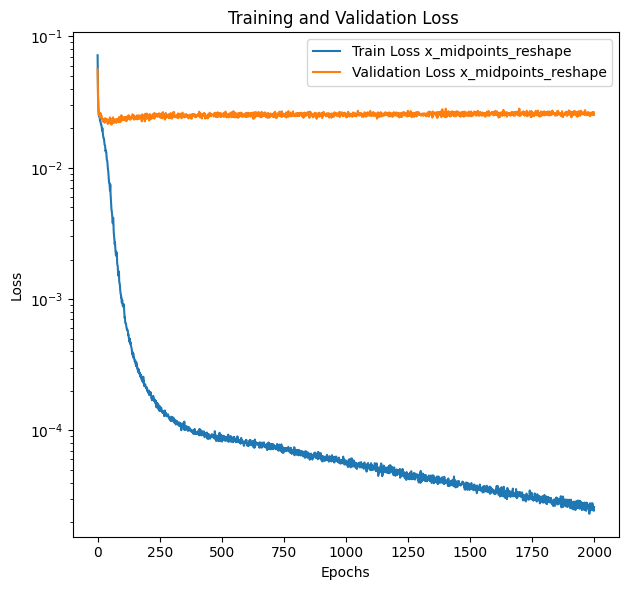

In [16]:


# Extract the losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']


train_loss_x_midpoints = history.history.get('x_midpoints_reshape_loss', train_loss)
val_loss_x_midpoints = history.history.get('val_x_midpoints_reshape_loss', val_loss)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2,1)
plt.plot(train_loss_x_midpoints, label='Train Loss x_midpoints_reshape')
plt.plot(val_loss_x_midpoints, label='Validation Loss x_midpoints_reshape')
plt.xlabel('Epochs')
plt.yscale('log')

plt.ylabel('Loss')
plt.title('Training and Validation Loss ')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
model_builder.model.save("/home/da886/Analysis/33KFixed_Mixed_5_32by32_95indexFor19kernel-l2reg.keras")
# loaded_model = tf.keras.models.load_model(
# "/home/da886/Analysis/30KFixed_13_SparsespotsrandomSPOTS.keras",
# )

In [19]:
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow as tf

# # Define the function for visualizing midpoints
# def visualize_midpoints(image, midpoints, title="Predicted Midpoint Visualization"):
#     """
#     Visualizes midpoints on an image without using a probability vector.

#     Parameters:
#     - image: A 3D tensor representing the image.
#     - midpoints: A 2D tensor representing the midpoint coordinates (x, y).
#     - title: The title of the plot.

#     Returns:
#     None (displays the image with midpoints).
#     """
#     # Convert to NumPy arrays for easier handling
#     image_np = image
#     midpoints_np = midpoints

#     # Denormalize image if necessary (adjust based on your normalization method)
#     denormalized_image = image_np  # Modify if normalization was applied during training

#     # Visualize the image
#     plt.figure(figsize=(4, 4))
#     plt.imshow(denormalized_image, cmap='gray')
#     plt.title(title)

#     # Plot midpoints directly, only if they are not (0, 0)
#     for i, (x, y) in enumerate(midpoints_np):
#         if x >= 0 and y >= 0:  # Only plot if the point is not (0, 0)
#             plt.scatter(x, y, color='red', s=5)

#     plt.show()

# # Create the validation dataset
# # val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_midpoints))
# # val_dataset = val_dataset.batch(800)
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# # inputs,targets = next(iter(train_dataset))
# # outputs = model_builder.model.predict(inputs)
# # # Initialize lists to collect the data
# all_images = []
# all_true_midpoints = []
# all_pred_midpoints = []

# # # Loop through each batch in the validation dataset, predict, and collect results
# # for i, (data_batch, midpoints_batch) in enumerate(val_dataset):

# for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
#     print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
#     # Get the model predictions
#     predictions =model_builder.model.predict(data_batch)

#     # Extend the lists to store data from each batch
#     all_images.extend(data_batch.numpy())  # Store all images
#     all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
#     all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# # Convert lists to arrays for easier indexing
# all_images = np.array(all_images)
# all_true_midpoints = np.array(all_true_midpoints)
# all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


W0000 00:00:1729634555.874463 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.875507 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.875875 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.876224 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.876534 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.876836 2936637 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.876921 2936631 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.877005 2936610 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729634555.877808 2936637 gp

Processing batch 2, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 3, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 4, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 5, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 6, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 7, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 8, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 9, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step   
Processing batch 10, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 11, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
Processing batch 12, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 13, batch 

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the function for visualizing midpoints
def visualize_midpoints_with_gt(image, true_midpoints, pred_midpoints, title="Predicted vs GT Midpoints"):
    """
    Visualizes ground truth and predicted midpoints on an image and draws lines to connect them.

    Parameters:
    - image: A 3D tensor representing the image.
    - true_midpoints: A 2D tensor representing the ground truth midpoint coordinates (x, y).
    - pred_midpoints: A 2D tensor representing the predicted midpoint coordinates (x, y).
    - title: The title of the plot.

    Returns:
    None (displays the image with midpoints and lines).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image

    # Ensure that midpoints are in the shape (num_points, 2) for both true and predicted midpoints
    true_midpoints_np = np.reshape(true_midpoints, (-1, 2))
    pred_midpoints_np = np.reshape(pred_midpoints, (-1, 2))

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(image_np, cmap='gray')
    plt.title(title)

    # Plot both ground truth and predicted midpoints
    for i, ((gt_x, gt_y), (pred_x, pred_y)) in enumerate(zip(true_midpoints_np, pred_midpoints_np)):
        if gt_x >= 0 and gt_y >= 0:  # Only plot if the GT point is valid
            plt.scatter(gt_x, gt_y, color='blue', label='Ground Truth' if i == 0 else "", s=30)
            plt.scatter(pred_x, pred_y, color='red', label='Prediction' if i == 0 else "", s=30)

            # Draw a line connecting the GT and predicted points
            plt.plot([gt_x, pred_x], [gt_y, pred_y], color='green', linewidth=1)

    # Add legend only once
    plt.legend()
    plt.show()

# Create the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
train_dataset = train_dataset.batch(800)

# Initialize lists to collect the data
all_images = []
all_true_midpoints = []
all_pred_midpoints = []

# Loop through each batch in the training dataset, predict, and collect results
for i, (data_batch, midpoints_batch) in enumerate(train_dataset):
    print(f"Processing batch {i + 1}, batch shape: {data_batch.shape}")
    
    # Get the model predictions
    predictions = model_builder.model.predict(data_batch)

    # Extend the lists to store data from each batch
    all_images.extend(data_batch.numpy())  # Store all images
    all_true_midpoints.extend(midpoints_batch.numpy())  # Store all true midpoints
    all_pred_midpoints.extend(predictions)  # Store all predicted midpoints

# Convert lists to arrays for easier indexing
all_images = np.array(all_images)
all_true_midpoints = np.array(all_true_midpoints)
all_pred_midpoints = np.array(all_pred_midpoints)


Processing batch 1, batch shape: (800, 32, 32)


2024-10-23 15:14:56.909282: W tensorflow/core/framework/dataset.cc:993] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
W0000 00:00:1729696497.069734 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.070713 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.071345 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.071982 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.072732 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.073380 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.074106 1761502 gpu_timer

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


W0000 00:00:1729696497.111935 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.112497 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.113071 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.113650 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.114314 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.115083 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.115985 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.116678 1761502 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729696497.117516 1761502 gp

Processing batch 2, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 3, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 4, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 5, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 6, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 7, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 8, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 9, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 10, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 11, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 12, batch shape: (800, 32, 32)
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Processing batch 13, batch sh

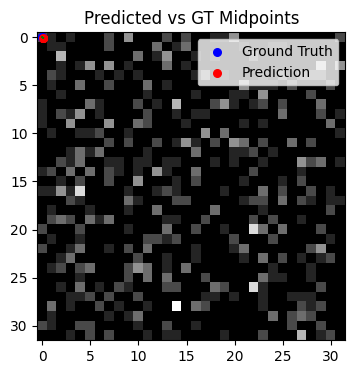

In [21]:
index_to_visualize = np.random.randint(0, len(all_images))
# Visualize the results for the first sample (you can change the index to visualize others)
visualize_midpoints_with_gt(all_images[index_to_visualize ], all_true_midpoints[index_to_visualize ]*np.max(centers), all_pred_midpoints[index_to_visualize ]*np.max(centers))


In [25]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_midpoints))
# train_dataset = train_dataset.batch(800)
# inputs,targets = next(iter(train_dataset))
# outputs = model_builder.model.predict(inputs)

In [20]:
all_images.shape,all_pred_midpoints.shape,all_true_midpoints.shape

((9600, 32, 32), (9600, 1, 13, 2), (9600, 1, 13, 2))

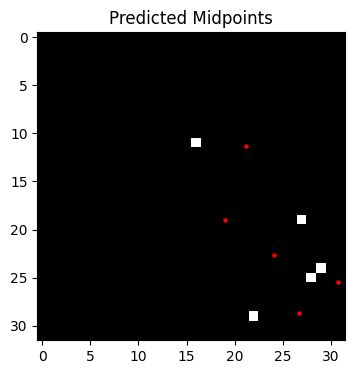

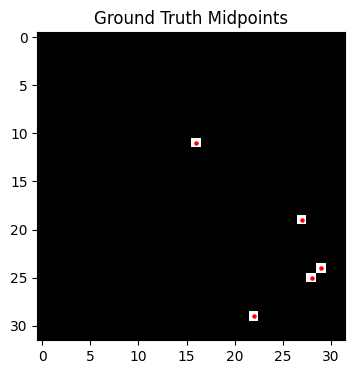

In [23]:

# Select an index to visualize from the entire dataset
index_to_visualize = np.random.randint(0, len(all_images))

# index_to_visualize = 11548
# Visualize the selected image with predicted and true midpoints
visualize_midpoints(all_images[index_to_visualize], all_pred_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Predicted Midpoints")
visualize_midpoints(all_images[index_to_visualize], all_true_midpoints[index_to_visualize, 0, :, :] * np.max(centers), title="Ground Truth Midpoints")


In [38]:
np.min(all_pred_midpoints)*np.max(centers),np.max(all_pred_midpoints)*np.max(centers)

(8.843155e-06, 30.997658)

In [39]:
np.min(all_true_midpoints)*np.max(centers),np.max(all_true_midpoints)*np.max(centers)

(0.0, 31.0)

In [40]:
np.min(train_images), np.max(train_images), np.min(train_midpoints)*np.max(centers), np.max(train_midpoints)*np.max(centers)

(0.0, 1.0, 0.0, 31.0)

In [41]:
all_pred_midpoints[2]*np.max(centers),all_true_midpoints[2]*np.max(centers)

(array([[[ 4.2590027,  3.908059 ],
         [27.263153 ,  4.3831873],
         [ 5.8743353,  6.6574388],
         [14.020337 ,  8.760142 ],
         [ 4.1754484, 10.7192545],
         [ 4.123699 , 11.2907295],
         [22.326601 , 11.401616 ],
         [ 7.203351 , 12.493043 ],
         [ 5.814977 , 12.613149 ],
         [21.202332 , 14.556165 ],
         [ 8.0557995, 17.444569 ],
         [ 8.055367 , 18.544151 ],
         [ 5.2744675, 26.596989 ]]], dtype=float32),
 array([[[ 4.,  3.],
         [28.,  6.],
         [ 6.,  7.],
         [14.,  9.],
         [ 4., 10.],
         [ 4., 10.],
         [22., 11.],
         [ 7., 12.],
         [ 6., 14.],
         [21., 15.],
         [ 8., 17.],
         [ 8., 18.],
         [ 5., 28.]]], dtype=float32))

In [35]:
centers

array([[[ 1., 35., 12.],
        [ 1., 63., 52.],
        [ 1., 11., 43.],
        ...,
        [ 1., 10., 33.],
        [ 1., 11., 48.],
        [ 1., 59., 49.]],

       [[ 1.,  5., 24.],
        [ 1., 34., 55.],
        [ 1., 42., 29.],
        ...,
        [ 1.,  2., 55.],
        [ 1., 13., 17.],
        [ 1., 45.,  8.]],

       [[ 1., 38., 36.],
        [ 1., 11., 33.],
        [ 1., 40., 40.],
        ...,
        [ 1., 45.,  5.],
        [ 1.,  8.,  7.],
        [ 1., 55., 37.]],

       ...,

       [[ 1., 50., 18.],
        [ 1., 20., 19.],
        [ 1., 63.,  8.],
        ...,
        [ 1., 32., 44.],
        [ 1., 63., 24.],
        [ 1., 51., 52.]],

       [[ 1.,  6., 33.],
        [ 1., 23., 59.],
        [ 1., 13., 48.],
        ...,
        [ 1., 26., 62.],
        [ 1., 20., 42.],
        [ 1., 53.,  2.]],

       [[ 1., 24., 40.],
        [ 1., 30., 43.],
        [ 1., 38., 55.],
        ...,
        [ 1., 31., 56.],
        [ 1., 21., 50.],
        [ 1., 15.,  6.]]

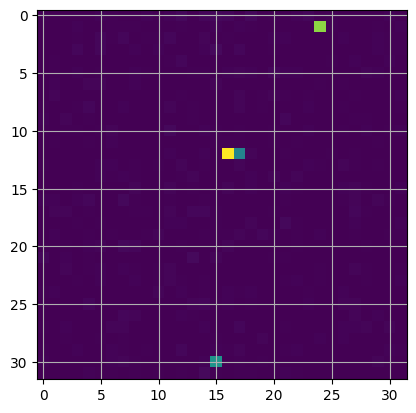

In [44]:
plt.imshow(images[2],)
plt.grid(True)

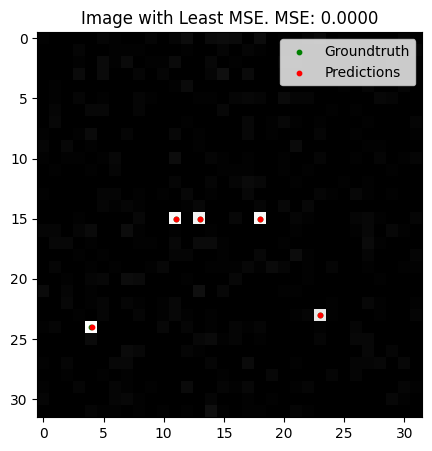

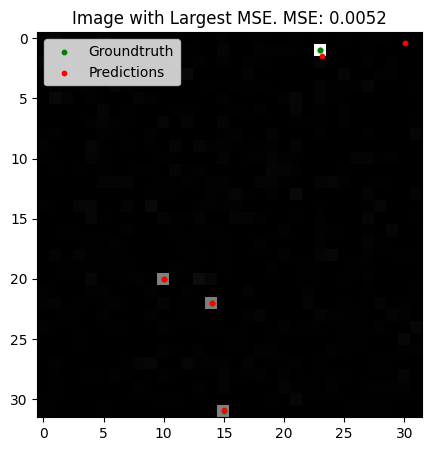

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize variables to track the min and max MSE
min_mse = float('inf')
max_mse = float('-inf')
min_mse_index = -1
max_mse_index = -1

# Loop through each prediction to calculate the MSE
for i in range(len(all_pred_midpoints)):
    mse = np.mean((all_pred_midpoints[i] - all_true_midpoints[i]) **2)
    
    if mse < min_mse:
        min_mse = mse
        min_mse_index = i
    
    if mse > max_mse:
        max_mse = mse
        max_mse_index = i
import numpy as np
import matplotlib.pyplot as plt

# Function to plot an image with its centers
def plot_image_with_centers(image, true_center, predicted_center, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')  # Display the image

    # Plot the actual center (Groundtruth)
    plt.scatter(true_center[:, 0], true_center[:, 1], color='green', label='Groundtruth', s=10)

    # Plot the predicted center
    plt.scatter(predicted_center[:, 0], predicted_center[:, 1], color='red', label='Predictions', s=10)

    plt.title(title)
    plt.legend()
    plt.show()






# Plotting the image with the least MSE
plot_image_with_centers(all_images[min_mse_index],
                        all_true_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[min_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Least MSE. MSE: {min_mse:.4f}')

# Plotting the image with the largest MSE
plot_image_with_centers(all_images[max_mse_index],
                        all_true_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        all_pred_midpoints[max_mse_index][0] * np.max(centers),  # Adjust for scaling if needed
                        f'Image with Largest MSE. MSE: {max_mse:.4f}')




In [22]:
max_mse_index

5266